In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf
keras = tf.keras
K = keras.backend

from resnet import Resnet18
from model import BiSeNet

In [2]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(0)

In [3]:
class Conv2D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding=0, *pargs, **kwargs):
        super(Conv2D, self).__init__()
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
        self.pad = keras.layers.ZeroPadding2D(padding=self.padding)
        self.conv = keras.layers.Conv2D(filters, 
                                        kernel_size=self.kernel_size,
                                        strides=self.strides,
                                        padding="valid", 
                                        *pargs, **kwargs)
    
    def call(self, x):
        x = self.pad(x)
#         x = K.spatial_2d_padding(x, ((self.padding, self.padding), (self.padding, self.padding)),
#                                  data_format=K.image_data_format())
        x = self.conv(x)
        return x
    
    def set_weights(self, weights):
        print("Conv2D set_weights() called.")
        self.conv.set_weights(weights)
        
        
class MaxPool2D(keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=None, padding=0, *pargs, **kwargs):
        super(MaxPool2D, self).__init__()
        
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
        self.pad = keras.layers.ZeroPadding2D(padding=self.padding)
        self.pool = keras.layers.MaxPool2D(pool_size=self.pool_size,
                                           strides=self.strides if self.strides is not None else self.pool_size, 
                                           padding="valid")
    
    def call(self, x):
        x = self.pad(x)
        x = self.pool(x)
        return x

In [4]:
def filter_dict_by_name(name, state_dict):
    return dict(filter(lambda t: t[0].startswith(name + "."),  state_dict.items()))


def strip_dict_key_prefix(state_dict, cut=1):
    """Strip parameter key prefix."""
    return {f"{'.'.join(k.split('.')[cut:])}": v for k, v in state_dict.items()}


def conv2d_weights_pth2tf(params_dict):
    """Convert conv2d weights from Pytorch to TensorFlow."""
    
    weights = []
    
    # gamma, beta, moving_mean, moving_variance
    for key in ["weight", "bias"]:
        if key not in params_dict:
            continue
            
        if key == "weight":
            weights.append(params_dict[key].permute(2, 3, 1, 0).detach().cpu().numpy())
        else:
            weights.append(params_dict[key].detach().cpu().numpy())
    
    return weights


def bn_weights_pth2tf(params_dict):
    """Convert batch norm weights from Pytorch to TensorFlow."""
    
    weights = []
    
    # gamma, beta, moving_mean, moving_variance
    for key in ["weight", "bias", "running_mean", "running_var"]:
        weights.append(params_dict[key].detach().cpu().numpy())
    
    return weights


def get_weight_conversion_fn(layer):
    """Get the appropriate weight conversion function given the layer."""
    
    if isinstance(layer, (keras.layers.Conv2D, Conv2D)):
        fn = conv2d_weights_pth2tf
    elif isinstance(layer, keras.layers.BatchNormalization):
        fn = bn_weights_pth2tf
    else:
        raise Exception(f"Unknown layer type: {type(layer)}")
        
    return fn


def th2tf_conv(prefix, state_dict):
    w = state_dict.get(f'{prefix}weight')
    b = state_dict.get(f'{prefix}bias', None)
    weights = [w.permute(2, 3, 1, 0).detach().cpu().numpy(), ]
    if b is not None: weights += [b.detach().cpu().numpy(), ]
    return weights

## Resnet18

In [5]:
net = Resnet18()
net = net.eval()

x = torch.randn(16, 3, 224, 224)
out = net(x)
print(out[0].size())
print(out[1].size())
print(out[2].size())

torch.Size([16, 128, 28, 28])
torch.Size([16, 256, 14, 14])
torch.Size([16, 512, 7, 7])


In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
#     return keras.layers.Conv2D(
# #         in_planes,
#         out_planes,
#         kernel_size=3,
#         strides=stride,
#         padding="same",
#         use_bias=False
#     )
    return Conv2D(
#         in_planes,
        out_planes,
        kernel_size=3,
        strides=stride,
        padding=1,
        use_bias=False
    )


class BasicBlock(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = keras.layers.BatchNormalization()
#         self.relu = nn.ReLU(inplace=True)
#         self.relu = keras.activations.relu
        self.relu = keras.layers.Activation("relu")
    
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = keras.models.Sequential()
            self.downsample.add(
                Conv2D(
#                     in_chan,
                    out_chan,
                    kernel_size=1,
                    strides=stride,
                    use_bias=False
                )
            )
            self.downsample.add(
                keras.layers.BatchNormalization()
            )

    def call(self, x):
        residual = self.conv1(x)
        residual = K.relu(self.bn1(residual))
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out
    
    def load_weigths_pytorch(self, state_dict):
        for layer_name in [
            "conv1",
            "bn1",
            "conv2",
            "bn2",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)

            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}")
#             print(layer_state_dict)
            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
        
        if self.downsample:
            print(f"{self.__class__.__name__}: self.downsample not None...")
            
            for idx, layer in enumerate(self.downsample.layers):
                print(f"{self.__class__.__name__}: \tidx: {idx}, layer type: {layer.__class__.__name__}")

                layer_state_dict = filter_dict_by_name(f"downsample.{idx}", state_dict)
                layer_state_dict = strip_dict_key_prefix(layer_state_dict, cut=2)
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    model = keras.models.Sequential()
    model.add(BasicBlock(in_chan, out_chan, stride=stride))
    for i in range(bnum - 1):
        model.add(BasicBlock(out_chan, out_chan, stride=1))
    return model


class TFResnet18(keras.models.Model):
    def __init__(self):
        super(TFResnet18, self).__init__()
        
#         self.conv1 = keras.layers.Conv2D(
# #             3, 
#             64, 
#             kernel_size=7, 
#             strides=2, 
#             padding="same",
#             use_bias=False
#         )
        self.conv1 = Conv2D(
            64,
            kernel_size=7,
            strides=2,
            padding=3,
            use_bias=False
        )
        self.bn1 = keras.layers.BatchNormalization()
#         self.maxpool = keras.layers.MaxPool2D(3, strides=2, padding="same")
        self.maxpool = MaxPool2D(3, strides=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)

    def call(self, x):
        x = self.conv1(x)
        x = K.relu(self.bn1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        feat8 = self.layer2(x) # 1/8
        feat16 = self.layer3(feat8) # 1/16
        feat32 = self.layer4(feat16) # 1/32
        return feat8, feat16, feat32
    
    def load_weights_pytorch(self, state_dict):
#         dummy_input = tf.random.normal((16, 224, 224, 3))
#         _ = self.predict(dummy_input)
        
        for layer_name in ["conv1", "bn1"]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")
            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            
            print()
        
        for seq_layer_name in [f"layer{i+1}" for i in range(4)]:
            seq_layer = getattr(self, seq_layer_name)
    
            print(f"{self.__class__.__name__}: Sequential layer: {seq_layer_name}")
            
            for idx, layer in enumerate(seq_layer.layers):
                print(f"{self.__class__.__name__}: \tidx: {idx}, layer type: {layer.__class__.__name__}")

                layer_state_dict = filter_dict_by_name(f"{seq_layer_name}.{idx}", state_dict)
                layer_state_dict = strip_dict_key_prefix(layer_state_dict, cut=2)
    #             print(layer_state_dict)
                layer.load_weigths_pytorch(layer_state_dict)
        
            print()
        
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [7]:
net_tf = TFResnet18()
x = tf.random.normal((16, 224, 224, 3))
out = net_tf(x)
print(out[0].shape)
print(out[1].shape)
print(out[2].shape)

(16, 28, 28, 128)
(16, 14, 14, 256)
(16, 7, 7, 512)


In [8]:
resnet18_state_dict = torch.load("resnet18-5c106cde.pth")

In [9]:
net.load_state_dict(resnet18_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])

In [10]:
net_tf.load_weights_pytorch(resnet18_state_dict)

TFResnet18: Setting weight for layer: conv1, type: Conv2D
TFResnet18: layer_state_dict keys: ['weight']
Conv2D set_weights() called.

TFResnet18: Setting weight for layer: bn1, type: BatchNormalization
TFResnet18: layer_state_dict keys: ['running_mean', 'running_var', 'weight', 'bias']

TFResnet18: Sequential layer: layer1
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
Conv2D set_weights() called.
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
Conv2D set_weights() called.
BasicBlock: Setting weight for layer: bn2
BasicBlock: Done loading weights!!!
TFResnet18: 	idx: 1, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
Conv2D set_weights() called.
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
Conv2D set_weights() called.
BasicBlock: Setting weight for layer: bn2
BasicBlock: Done loading weights!!!

TFResnet18: Sequential layer: layer2
TFResnet18: 	idx:

### Verify prediction

In [11]:
fixed_input = np.random.rand(16, 224, 224, 3).astype(np.float32)

In [12]:
pred_tf = net_tf(fixed_input)

In [13]:
pred_tf[0].shape

TensorShape([16, 28, 28, 128])

In [14]:
net.eval()

pred = net(torch.from_numpy(fixed_input).permute(0, 3, 1, 2))

In [15]:
pred[0].shape

torch.Size([16, 128, 28, 28])

In [16]:
np.allclose(pred_tf[0].numpy(), 
            pred[0].permute(0, 2, 3, 1).detach().numpy())

False

In [17]:
pred_tf[0].numpy()

array([[[[0.12830877, 0.48721805, 0.        , ..., 0.        ,
          0.51415837, 0.00155158],
         [0.78083277, 0.06962453, 0.        , ..., 0.        ,
          0.28840283, 0.        ],
         [0.        , 0.45388985, 0.        , ..., 0.        ,
          0.29491904, 0.09742095],
         ...,
         [0.9117039 , 0.4506205 , 0.        , ..., 0.        ,
          0.4612979 , 0.        ],
         [0.        , 0.6288354 , 0.        , ..., 0.        ,
          0.470747  , 0.        ],
         [0.5796453 , 0.4545493 , 0.        , ..., 0.        ,
          0.5191339 , 0.05757673]],

        [[0.12452961, 0.33969688, 0.        , ..., 0.        ,
          0.30230257, 0.21753067],
         [0.13587937, 0.        , 0.        , ..., 0.        ,
          0.18785004, 0.        ],
         [0.        , 0.2928079 , 0.        , ..., 0.        ,
          0.09992133, 0.10608176],
         ...,
         [0.        , 0.157009  , 0.        , ..., 0.        ,
          0.24658105, 0. 

In [18]:
pred[0].permute(0, 2, 3, 1).detach().numpy()

array([[[[0.13472125, 0.49329752, 0.        , ..., 0.        ,
          0.5185292 , 0.00187629],
         [0.7935079 , 0.05923128, 0.        , ..., 0.        ,
          0.29169345, 0.        ],
         [0.        , 0.45032078, 0.        , ..., 0.        ,
          0.29808313, 0.09487873],
         ...,
         [0.9252046 , 0.45001596, 0.        , ..., 0.        ,
          0.46765763, 0.        ],
         [0.        , 0.627446  , 0.        , ..., 0.        ,
          0.4757743 , 0.        ],
         [0.5937682 , 0.45688918, 0.        , ..., 0.        ,
          0.52470505, 0.05763094]],

        [[0.13140416, 0.34225163, 0.        , ..., 0.        ,
          0.30475402, 0.22151433],
         [0.14041626, 0.        , 0.        , ..., 0.        ,
          0.18961377, 0.        ],
         [0.        , 0.27854437, 0.        , ..., 0.        ,
          0.09838057, 0.10115657],
         ...,
         [0.        , 0.14647159, 0.        , ..., 0.        ,
          0.25179288, 0. 

In [19]:
a = pred_tf[0].numpy()[0][..., :3]/pred_tf[0].numpy()[0][..., :3].max()
b = pred[0].permute(0, 2, 3, 1).detach().numpy()[0][..., :3]/pred[0].permute(0, 2, 3, 1).detach().numpy()[0][..., :3].max()

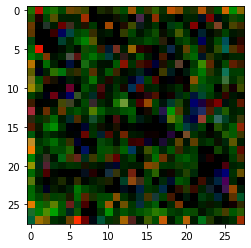

In [20]:
plt.imshow(a)

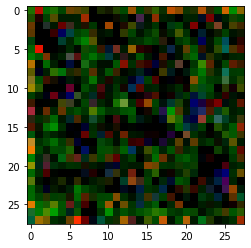

In [21]:
plt.imshow(b)

In [22]:
np.abs(
    a - b
).max()

0.016361237

In [23]:
np.abs(
    a - b
)

array([[[0.00408848, 0.00071841, 0.        ],
        [0.00145531, 0.0101153 , 0.        ],
        [0.        , 0.00887769, 0.        ],
        ...,
        [0.00054449, 0.00620097, 0.        ],
        [0.        , 0.00913852, 0.        ],
        [0.00527108, 0.00363258, 0.        ]],

       [[0.00454679, 0.00199804, 0.        ],
        [0.00232583, 0.        , 0.        ],
        [0.        , 0.01636124, 0.        ],
        ...,
        [0.        , 0.01134174, 0.        ],
        [0.00217453, 0.00687271, 0.        ],
        [0.        , 0.00584498, 0.        ]],

       [[0.00105953, 0.00225767, 0.        ],
        [0.        , 0.01290039, 0.        ],
        [0.00259794, 0.01177233, 0.00387168],
        ...,
        [0.        , 0.00786332, 0.        ],
        [0.00121567, 0.00700271, 0.        ],
        [0.00099708, 0.00640839, 0.        ]],

       ...,

       [[0.00056118, 0.00100982, 0.        ],
        [0.        , 0.00736159, 0.        ],
        [0.00368425, 0

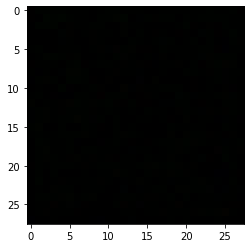

In [24]:
plt.imshow(
np.abs(
    a - b
)
)

## ConvBNReLU

In [25]:
class ConvBNReLU(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        
        self.conv = Conv2D(
            out_chan,
            kernel_size=ks,
            strides=stride,
            padding=padding,
            use_bias=False
        )
        
        self.bn = keras.layers.BatchNormalization()

    def call(self, x):
        x = self.conv(x)
        x = K.relu(self.bn(x))
        return x
    
    def load_weights_pytorch(self, state_dict):
#         dummy = self.create_dummy_input()
#         _ = self.call(dummy)
        
        for layer_name in ["conv", "bn"]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")
        
    def create_dummy_input(self):
        return np.random.randn(2, 224, 224, 3).astype(np.float32)

In [26]:
from model import ConvBNReLU as THConvBNReLU

In [27]:
conv_bn_relu = THConvBNReLU(in_chan=3, out_chan=3)

In [28]:
conv_bn_relu_tf = ConvBNReLU(in_chan=3, out_chan=3)

In [29]:
fixed_in = conv_bn_relu_tf.create_dummy_input()
fixed_in.shape

(2, 224, 224, 3)

In [30]:
_ = conv_bn_relu_tf(fixed_in)

In [31]:
conv_bn_relu_tf.load_weights_pytorch(
    conv_bn_relu.state_dict()
)

ConvBNReLU: Setting weight for layer: conv, type: Conv2D
ConvBNReLU: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
ConvBNReLU: conv:Done!

ConvBNReLU: Setting weight for layer: bn, type: BatchNormalization
ConvBNReLU: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']
ConvBNReLU: bn:Done!

ConvBNReLU: Done loading weights!!!


In [32]:
conv_bn_relu = conv_bn_relu.eval()

out = conv_bn_relu(torch.from_numpy(fixed_in).permute(0, 3, 1, 2))
out = out.permute(0, 2, 3, 1).detach().numpy()
print(out.shape)

(2, 224, 224, 3)


In [33]:
out_tf = conv_bn_relu_tf(fixed_in)
out_tf = out_tf.numpy()
print(out_tf.shape)

(2, 224, 224, 3)


In [34]:
out[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.06974933, 0.52080786],
        [0.97165436, 0.208961  , 0.        ],
        ...,
        [0.        , 0.        , 0.8892803 ],
        [0.47238412, 0.        , 0.        ],
        [0.6377998 , 1.290462  , 0.        ]],

       [[0.2590489 , 0.        , 0.11733416],
        [0.        , 0.        , 1.5423522 ],
        [0.10514125, 0.        , 0.        ],
        ...,
        [1.0365778 , 0.        , 0.        ],
        [0.        , 0.        , 0.07916266],
        [0.7581233 , 0.        , 0.3582374 ]],

       [[0.        , 0.60943395, 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.4970398 ],
        ...,
        [0.        , 0.        , 0.        ],
        [2.1569362 , 0.21377186, 0.        ],
        [0.        , 0.        , 0.9728399 ]],

       ...,

       [[0.        , 0.709554  , 0.721923  ],
        [1.2244221 , 0.        , 0.87446314],
        [0.        , 0

In [35]:
out_tf[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.06971488, 0.5205503 ],
        [0.97117376, 0.2088576 , 0.        ],
        ...,
        [0.        , 0.        , 0.88884044],
        [0.47215044, 0.        , 0.        ],
        [0.6374843 , 1.2898237 , 0.        ]],

       [[0.25892088, 0.        , 0.1172761 ],
        [0.        , 0.        , 1.5415893 ],
        [0.10508922, 0.        , 0.        ],
        ...,
        [1.0360653 , 0.        , 0.        ],
        [0.        , 0.        , 0.0791235 ],
        [0.75774825, 0.        , 0.3580602 ]],

       [[0.        , 0.6091324 , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.49679378],
        ...,
        [0.        , 0.        , 0.        ],
        [2.155869  , 0.2136661 , 0.        ],
        [0.        , 0.        , 0.9723587 ]],

       ...,

       [[0.        , 0.7092032 , 0.72156596],
        [1.2238164 , 0.        , 0.8740305 ],
        [0.        , 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


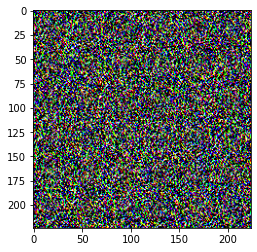

In [36]:
plt.imshow(out[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


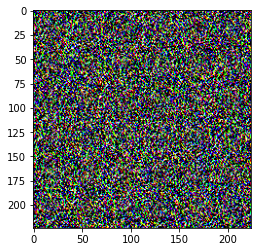

In [37]:
plt.imshow(out_tf[0])

In [38]:
(out_tf.min(), out_tf.max()), (out.min(), out.max())

((0.0, 3.9882412), (0.0, 3.9902148))

In [39]:
np.abs(out_tf - out).max()/max(out_tf.max(), out.max()) * 100

0.049461721209809184

## BiSeNetOutput

In [40]:
class BiSeNetOutput(keras.layers.Layer):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        
        self.in_chan = in_chan
        self.mid_chan = mid_chan
        self.n_classes = n_classes
        
        self.conv = ConvBNReLU(
            in_chan, 
            mid_chan, 
            ks=3, 
            stride=1, 
            padding=1
        )
        self.conv_out = Conv2D(
#             mid_chan, 
            n_classes, 
            kernel_size=1, 
            use_bias=False
        )

    def call(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x
    
    def load_weights_pytorch(self, state_dict):
#         dummy = self.create_dummy_input()
#         _ = self.call(dummy)
        
        for layer_name in [
            "conv", 
            "conv_out"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
            
        print(f"{self.__class__.__name__}: Done loading weights!!!")
        
    def create_dummy_input(self):
        return np.random.randn(2, 224, 224, self.in_chan).astype(np.float32)

In [41]:
from model import BiSeNetOutput as THBiseNetOutput

In [42]:
bisenetoutput = THBiseNetOutput(3, 64, 3)

In [43]:
bisenetoutput_tf = BiSeNetOutput(3, 64, 3)

In [44]:
fixed_in = bisenetoutput_tf.create_dummy_input()
fixed_in.shape

(2, 224, 224, 3)

In [45]:
_ = bisenetoutput_tf(fixed_in)

In [46]:
bisenetoutput_tf.load_weights_pytorch(bisenetoutput.state_dict())

BiSeNetOutput: Setting weight for layer: conv, type: ConvBNReLU
BiSeNetOutput: layer_state_dict keys: ['conv.weight', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked']
ConvBNReLU: Setting weight for layer: conv, type: Conv2D
ConvBNReLU: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
ConvBNReLU: conv:Done!

ConvBNReLU: Setting weight for layer: bn, type: BatchNormalization
ConvBNReLU: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']
ConvBNReLU: bn:Done!

ConvBNReLU: Done loading weights!!!
BiSeNetOutput: conv:Done!

BiSeNetOutput: Setting weight for layer: conv_out, type: Conv2D
BiSeNetOutput: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
BiSeNetOutput: conv_out:Done!

BiSeNetOutput: Done loading weights!!!


In [47]:
bisenetoutput.eval()

out = bisenetoutput(torch.from_numpy(fixed_in).permute(0, 3, 1, 2))
out = out.permute(0, 2, 3, 1).detach().numpy()

In [48]:
out_tf = bisenetoutput_tf(fixed_in).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


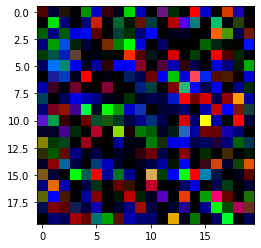

In [49]:
plt.imshow(out[0][:20,:20,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


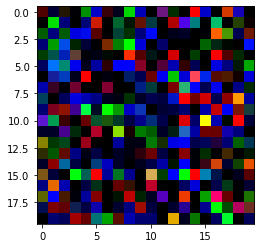

In [50]:
plt.imshow(out_tf[0][:20,:20,:])

In [51]:
out_tf[0]

array([[[ 0.31870872, -0.00328887, -0.15372811],
        [-0.0203818 , -0.13205735,  0.20505852],
        [ 0.13726635,  0.08632766, -0.48999304],
        ...,
        [-1.2207072 , -0.18108344, -0.21320349],
        [ 0.22773466, -0.06034687, -0.3537744 ],
        [-0.5686707 , -0.18398738,  0.46643022]],

       [[-0.57932234, -0.85243756, -0.09308814],
        [-0.49299514,  0.8815676 , -0.5683968 ],
        [-0.39876083, -0.07058048,  0.47271127],
        ...,
        [-0.00414298,  1.0993026 , -0.44272864],
        [ 0.9692594 , -0.0557696 ,  0.5166626 ],
        [ 0.64681786, -0.31409243, -0.10924926]],

       [[-0.62489086,  0.3631387 , -0.38891476],
        [-0.39692983, -0.17344478,  0.48804766],
        [-0.45561758,  0.354726  , -0.34569228],
        ...,
        [-1.1082045 , -0.5772949 ,  0.4397173 ],
        [-0.26088914,  0.21772613,  0.61800677],
        [-0.562843  ,  0.42478257,  0.1757238 ]],

       ...,

       [[ 0.63745314,  0.25506762,  0.12051576],
        [-0

In [52]:
out[0]

array([[[ 0.31886646, -0.00329052, -0.15380421],
        [-0.02039177, -0.13212262,  0.20516005],
        [ 0.13733436,  0.08637036, -0.49023566],
        ...,
        [-1.2213113 , -0.18117307, -0.21330914],
        [ 0.22784737, -0.06037666, -0.3539495 ],
        [-0.56895214, -0.18407845,  0.46666104]],

       [[-0.5796089 , -0.8528595 , -0.09313411],
        [-0.4932388 ,  0.8820039 , -0.5686782 ],
        [-0.3989583 , -0.07061557,  0.4729454 ],
        ...,
        [-0.00414507,  1.0998466 , -0.44294757],
        [ 0.96973914, -0.05579715,  0.5169182 ],
        [ 0.64713794, -0.31424788, -0.1093033 ]],

       [[-0.62520003,  0.3633185 , -0.38910726],
        [-0.39712623, -0.17353056,  0.48828915],
        [-0.4558433 ,  0.35490143, -0.34586322],
        ...,
        [-1.1087528 , -0.57758087,  0.43993488],
        [-0.26101813,  0.21783383,  0.6183125 ],
        [-0.5631216 ,  0.42499277,  0.17581055]],

       ...,

       [[ 0.6377687 ,  0.25519386,  0.12057547],
        [-0

In [53]:
np.abs(out_tf - out).max()/max(out_tf.max(), out.max()) * 100

0.06548498058691621

## AttentionRefinementModule

In [54]:
class AttentionRefinementModule(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        
        self.in_chan = in_chan
        self.out_chan = out_chan
        
        self.conv = ConvBNReLU(
            in_chan, 
            out_chan, 
            ks=3, 
            stride=1, 
            padding=1
        )
        
        self.conv_atten = Conv2D(
#           out_chan, 
            out_chan, 
            kernel_size=1, 
            use_bias=False
        )
        
        self.bn_atten = keras.layers.BatchNormalization()
        self.sigmoid_atten = keras.layers.Activation("sigmoid")
        
    def call(self, x):
        feat = self.conv(x)
        
#         atten = K.pool2d(feat, 
#                          pool_size=feat.shape[1:2+1],
#                          pool_mode="avg",
#                          padding="valid")
        atten = K.mean(feat, axis=[1, 2], keepdims=True)
    
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        
        out = tf.math.multiply(feat, atten)
        return out
    
    def load_weights_pytorch(self, state_dict):
#         dummy = self.create_dummy_input()
#         _ = self.call(dummy)
        
        for layer_name in [
            "conv", 
            "conv_atten",
            "bn_atten"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")
        
    def create_dummy_input(self):
        return np.random.randn(2, 224, 224, self.in_chan).astype(np.float32)

In [55]:
from model import AttentionRefinementModule as THAttentionRefinementModule

In [56]:
arm = THAttentionRefinementModule(3, 3)

In [57]:
arm_tf = AttentionRefinementModule(3, 3)

In [58]:
fixed_in = arm_tf.create_dummy_input()
fixed_in.shape

(2, 224, 224, 3)

In [59]:
_ = arm_tf(fixed_in)

In [60]:
arm_tf.load_weights_pytorch(arm.state_dict())

AttentionRefinementModule: Setting weight for layer: conv, type: ConvBNReLU
AttentionRefinementModule: layer_state_dict keys: ['conv.weight', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked']
ConvBNReLU: Setting weight for layer: conv, type: Conv2D
ConvBNReLU: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
ConvBNReLU: conv:Done!

ConvBNReLU: Setting weight for layer: bn, type: BatchNormalization
ConvBNReLU: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']
ConvBNReLU: bn:Done!

ConvBNReLU: Done loading weights!!!
AttentionRefinementModule: conv:Done!

AttentionRefinementModule: Setting weight for layer: conv_atten, type: Conv2D
AttentionRefinementModule: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
AttentionRefinementModule: conv_atten:Done!

AttentionRefinementModule: Setting weight for layer: bn_atten, type: BatchNormalization
AttentionRefinementModule: layer_state_dic

In [61]:
arm.eval()

out = arm(torch.from_numpy(fixed_in).permute(0, 3, 1, 2))
out = out.permute(0, 2, 3, 1).detach().numpy()

In [62]:
out.shape

(2, 224, 224, 3)

In [63]:
out_tf = arm_tf(fixed_in).numpy()

In [64]:
out_tf.shape

(2, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


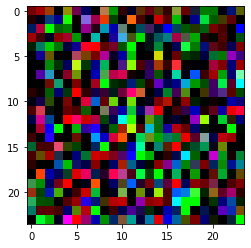

In [65]:
plt.imshow(out[0][:24,:24,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


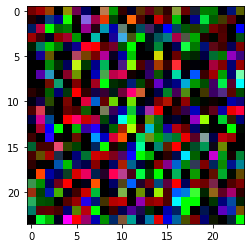

In [66]:
plt.imshow(out_tf[0][:24,:24,:])

In [67]:
out[0][:24,:24,:]

array([[[0.45324707, 0.        , 0.        ],
        [0.6302571 , 0.        , 0.        ],
        [0.6051916 , 0.24820022, 0.        ],
        ...,
        [0.        , 0.        , 0.05751219],
        [0.        , 0.07268541, 0.46551177],
        [0.34160268, 0.37408206, 0.        ]],

       [[0.13003811, 0.        , 0.        ],
        [0.        , 0.        , 0.09558962],
        [0.04560955, 0.22762097, 0.4979257 ],
        ...,
        [0.26483244, 0.22861831, 0.        ],
        [0.37565368, 0.        , 0.03388792],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.10775334, 0.37864152],
        [0.7117393 , 0.        , 0.23845813],
        [0.        , 1.0459983 , 0.        ],
        ...,
        [0.29768932, 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.2692375 ]],

       ...,

       [[0.16121493, 0.68298143, 0.37569958],
        [0.        , 0.33001196, 0.        ],
        [0.        , 0

In [68]:
out_tf[0][:24,:24,:]

array([[[0.45303437, 0.        , 0.        ],
        [0.6299613 , 0.        , 0.        ],
        [0.60490763, 0.24808758, 0.        ],
        ...,
        [0.        , 0.        , 0.0574903 ],
        [0.        , 0.07265247, 0.46533477],
        [0.34144238, 0.37391227, 0.        ]],

       [[0.12997712, 0.        , 0.        ],
        [0.        , 0.        , 0.09555324],
        [0.04558819, 0.22751774, 0.49773645],
        ...,
        [0.2647082 , 0.22851449, 0.        ],
        [0.3754773 , 0.        , 0.03387507],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.10770441, 0.3784975 ],
        [0.7114051 , 0.        , 0.23836748],
        [0.        , 1.0455235 , 0.        ],
        ...,
        [0.29754943, 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.2687551 ]],

       ...,

       [[0.16113928, 0.68267155, 0.37555677],
        [0.        , 0.32986218, 0.        ],
        [0.        , 0

In [69]:
np.absolute(out[0] - out_tf[0]).max()/max(out[0].max(), out_tf[0].max()) * 100

0.045391530147753656

## ContextPath

In [70]:
class ContextPath(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        
        self.resnet = TFResnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)
        
    def call(self, x):
        H0, W0 = x.shape[1:2+1]
        
        feat8, feat16, feat32 = self.resnet(x)
        
        H8, W8 = feat8.shape[1:2+1]
        H16, W16 = feat16.shape[1:2+1]
        H32, W32 = feat32.shape[1:2+1]

#         avg = K.pool2d(feat32, 
#                        pool_size=feat32.shape[1:2+1],
#                        pool_mode="avg",
#                        padding="valid")
        avg = K.mean(feat32, axis=[1, 2], keepdims=True)
        avg = self.conv_avg(avg)
        avg_up = tf.image.resize(avg, (H32, W32), method="nearest")

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = tf.image.resize(feat32_sum, (H16, W16), method="nearest")
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = tf.image.resize(feat16_sum, (H8, W8), method="nearest")
        feat16_up = self.conv_head16(feat16_up)

        return feat8, feat16_up, feat32_up  # x8, x8, x16
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "resnet", 
            "arm16",
            "arm32",
            "conv_head32",
            "conv_head16",
            "conv_avg"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")
        
    def create_dummy_input(self):
        return np.random.randn(2, 224, 224, 3).astype(np.float32)

In [71]:
from model import ContextPath as THContextPath

In [72]:
cp = THContextPath()

In [73]:
cp_tf = ContextPath()

In [74]:
fixed_in = cp_tf.create_dummy_input()
fixed_in.shape

(2, 224, 224, 3)

In [75]:
_ = cp_tf(fixed_in)

In [76]:
cp_tf.load_weights_pytorch(cp.state_dict())

ContextPath: Setting weight for layer: resnet, type: TFResnet18
ContextPath: layer_state_dict keys: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num

In [77]:
cp.eval()

outs = cp(torch.from_numpy(fixed_in).permute(0, 3, 1, 2))
out = outs[0].permute(0, 2, 3, 1).detach().numpy()

In [78]:
outs_tf = cp_tf(fixed_in)
out_tf = outs_tf[0].numpy()

In [79]:
out

array([[[[6.5691687e-02, 2.4635933e-01, 0.0000000e+00, ...,
          3.1330776e-01, 7.5373018e-01, 0.0000000e+00],
         [1.1249478e+00, 2.8541768e-01, 0.0000000e+00, ...,
          0.0000000e+00, 7.3764926e-01, 0.0000000e+00],
         [7.1883482e-01, 4.1824132e-01, 0.0000000e+00, ...,
          0.0000000e+00, 6.5711838e-01, 9.2780329e-02],
         ...,
         [5.5741251e-01, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 5.6481814e-01, 0.0000000e+00],
         [0.0000000e+00, 1.1430794e-01, 0.0000000e+00, ...,
          5.0175071e-02, 3.5733819e-01, 0.0000000e+00],
         [1.3205328e+00, 2.9990822e-01, 0.0000000e+00, ...,
          3.4001052e-01, 6.2439716e-01, 9.6380293e-02]],

        [[0.0000000e+00, 2.2494262e-01, 0.0000000e+00, ...,
          0.0000000e+00, 4.2394930e-01, 9.0238988e-02],
         [5.1290683e-02, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 2.9321709e-01, 0.0000000e+00],
         [0.0000000e+00, 3.9662945e-01, 0.0000000e+00, .

In [80]:
out_tf

array([[[[0.05788459, 0.24517053, 0.        , ..., 0.33367193,
          0.74569815, 0.        ],
         [1.1105301 , 0.28520644, 0.        , ..., 0.        ,
          0.7317884 , 0.        ],
         [0.7143715 , 0.41644132, 0.        , ..., 0.        ,
          0.64625454, 0.09908024],
         ...,
         [0.5549027 , 0.        , 0.        , ..., 0.        ,
          0.5611999 , 0.        ],
         [0.        , 0.1187436 , 0.        , ..., 0.05515748,
          0.35543048, 0.        ],
         [1.2907923 , 0.2973286 , 0.        , ..., 0.34139127,
          0.6173466 , 0.09956716]],

        [[0.        , 0.22994593, 0.        , ..., 0.        ,
          0.42258155, 0.09204747],
         [0.04773705, 0.        , 0.        , ..., 0.        ,
          0.29263452, 0.        ],
         [0.        , 0.4059626 , 0.        , ..., 0.        ,
          0.27771094, 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.07990663, 0. 

## FeatureFusionModule

In [81]:
class FeatureFusionModule(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        
        self.in_chan = in_chan
        self.out_chan = out_chan
        
        self.convblk = ConvBNReLU(
            in_chan,
            out_chan,
            ks=1,
            stride=1,
            padding=0
        )
        
        self.conv1 = Conv2D(
#             out_chan,
            out_chan//4,
            kernel_size=1,
            strides=1,
            padding=0,
            use_bias=False
        )
        self.conv2 = Conv2D(
#             out_chan//4,
            out_chan,
            kernel_size=1,
            strides=1,
            padding=0,
            use_bias=False
        )

    def call(self, inputs):
        fsp, fcp = inputs
        
        fcat = K.concatenate([fsp, fcp], axis=3)
        
        feat = self.convblk(fcat)
        
#         atten = K.pool2d(feat, 
#                          pool_size=feat.shape[1:2+1], 
#                          pool_mode="avg",
#                          padding="valid")
        atten = K.mean(feat, axis=[1, 2], keepdims=True)

        atten = self.conv1(atten)
        atten = K.relu(atten)
        atten = self.conv2(atten)
        atten = K.sigmoid(atten)
        
        feat_atten = tf.math.multiply(feat, atten)
        
        feat_out = feat_atten + feat
        return feat_out
    
    def load_weights_pytorch(self, state_dict):
#         dummy = self.create_dummy_input()
#         _ = self.call((dummy, dummy))
        
        for layer_name in [
            "convblk", 
            "conv1",
            "conv2",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")
        
    def create_dummy_input(self):
        return np.random.randn(2, 224, 224, self.in_chan//2).astype(np.float32)

In [82]:
from model import FeatureFusionModule as THFeatureFusionModule

In [83]:
ffm = THFeatureFusionModule(256, 128)

In [84]:
ffm_tf = FeatureFusionModule(256, 128)

In [85]:
fixed_in = ffm_tf.create_dummy_input()
fixed_in.shape

(2, 224, 224, 128)

In [86]:
_ = ffm_tf((fixed_in, fixed_in))

In [87]:
ffm_tf.load_weights_pytorch(ffm.state_dict())

FeatureFusionModule: Setting weight for layer: convblk, type: ConvBNReLU
FeatureFusionModule: layer_state_dict keys: ['conv.weight', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked']
ConvBNReLU: Setting weight for layer: conv, type: Conv2D
ConvBNReLU: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
ConvBNReLU: conv:Done!

ConvBNReLU: Setting weight for layer: bn, type: BatchNormalization
ConvBNReLU: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']
ConvBNReLU: bn:Done!

ConvBNReLU: Done loading weights!!!
FeatureFusionModule: convblk:Done!

FeatureFusionModule: Setting weight for layer: conv1, type: Conv2D
FeatureFusionModule: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
FeatureFusionModule: conv1:Done!

FeatureFusionModule: Setting weight for layer: conv2, type: Conv2D
FeatureFusionModule: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
FeatureFusionModule

In [88]:
ffm.eval()

out = ffm(torch.from_numpy(fixed_in).permute(0, 3, 1, 2), 
          torch.from_numpy(fixed_in).permute(0, 3, 1, 2))
out = out.permute(0, 2, 3, 1).detach().numpy()

In [89]:
out_tf = ffm_tf((fixed_in, fixed_in)).numpy()

In [90]:
out

array([[[[0.67250437, 1.6268048 , 0.        , ..., 0.        ,
          0.        , 2.900554  ],
         [0.        , 0.        , 2.0703382 , ..., 0.        ,
          1.1135118 , 1.9533644 ],
         [0.        , 0.        , 0.        , ..., 0.03796231,
          0.        , 0.        ],
         ...,
         [0.        , 0.25104174, 1.1158677 , ..., 0.483744  ,
          1.2947755 , 0.        ],
         [0.45048028, 0.        , 0.15844525, ..., 0.0388664 ,
          1.1370738 , 0.        ],
         [0.        , 0.        , 0.35965326, ..., 0.        ,
          0.78129256, 1.3571644 ]],

        [[0.        , 1.2007705 , 0.        , ..., 2.105271  ,
          0.65598625, 1.7361606 ],
         [0.6262214 , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.93278885, ..., 0.47342363,
          0.25875798, 0.8071315 ],
         ...,
         [0.09679545, 1.7210734 , 0.2778884 , ..., 0.        ,
          0.        , 0.1

In [91]:
out_tf

array([[[[0.6721825 , 1.625966  , 0.        , ..., 0.        ,
          0.        , 2.8990822 ],
         [0.        , 0.        , 2.0693505 , ..., 0.        ,
          1.1129271 , 1.9523726 ],
         [0.        , 0.        , 0.        , ..., 0.03794418,
          0.        , 0.        ],
         ...,
         [0.        , 0.2509122 , 1.1153358 , ..., 0.48350966,
          1.2940962 , 0.        ],
         [0.45026457, 0.        , 0.15836969, ..., 0.03884735,
          1.1364768 , 0.        ],
         [0.        , 0.        , 0.3594813 , ..., 0.        ,
          0.7808827 , 1.3564755 ]],

        [[0.        , 1.2001511 , 0.        , ..., 2.1042514 ,
          0.6556417 , 1.7352788 ],
         [0.6259221 , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.93234396, ..., 0.47319424,
          0.25862193, 0.8067218 ],
         ...,
         [0.0967491 , 1.7201862 , 0.27775586, ..., 0.        ,
          0.        , 0.1

In [92]:
np.abs(out - out_tf).max()/max(out.max(), out_tf.max()) * 100

0.052816502284258604

## BiSeNet

In [93]:
class TFBiSeNet(keras.models.Model):
    def __init__(self, n_classes, *args, **kwargs):
        super(TFBiSeNet, self).__init__()
        
        self.n_classes = n_classes
        
        self.cp = ContextPath()
        ## here self.sp is deleted
        
        self.ffm = FeatureFusionModule(256, 256)
        
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)

    def call(self, x):
        H, W = x.shape[1:2+1]
    
        feat_res8, feat_cp8, feat_cp16 = self.cp(x)  # here return res3b1 feature
        
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm((feat_sp, feat_cp8))

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

#         feat_out = tf.image.resize(feat_out, (H, W), method="bilinear", align_corners=True)
#         feat_out16 = tf.image.resize(feat_out16, (H, W), method="bilinear", align_corners=True)
#         feat_out32 = tf.image.resize(feat_out32, (H, W), method="bilinear", align_corners=True)
        feat_out = tf.compat.v1.image.resize_bilinear(feat_out, (H, W), align_corners=True)
        feat_out16 = tf.compat.v1.image.resize_bilinear(feat_out16, (H, W), align_corners=True)
        feat_out32 = tf.compat.v1.image.resize_bilinear(feat_out32, (H, W), align_corners=True)
        
        return feat_out, feat_out16, feat_out32
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "cp", 
            "ffm",
            "conv_out",
            "conv_out16",
            "conv_out32",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict, 1)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")
        
    def create_dummy_input(self):
        return np.random.randn(2, 224, 224, 3).astype(np.float32)

In [94]:
model_state_dict = torch.load(os.path.join("res/cp", "79999_iter.pth"))

print(f"{'Parameter':80s}Size")
print("-" * 100)
for k, v in model_state_dict.items():
    print(f"{k:80s}{list(v.shape)}")

Parameter                                                                       Size
----------------------------------------------------------------------------------------------------
cp.resnet.conv1.weight                                                          [64, 3, 7, 7]
cp.resnet.bn1.weight                                                            [64]
cp.resnet.bn1.bias                                                              [64]
cp.resnet.bn1.running_mean                                                      [64]
cp.resnet.bn1.running_var                                                       [64]
cp.resnet.bn1.num_batches_tracked                                               []
cp.resnet.layer1.0.conv1.weight                                                 [64, 64, 3, 3]
cp.resnet.layer1.0.bn1.weight                                                   [64]
cp.resnet.layer1.0.bn1.bias                                                     [64]
cp.resnet.layer1.0.bn1.running_m

In [95]:
from model import BiSeNet as THBiSeNet

In [96]:
net = THBiSeNet(n_classes=19)

In [97]:
net_tf = TFBiSeNet(n_classes=19)

In [98]:
net.load_state_dict(model_state_dict)

<All keys matched successfully>

In [99]:
in_ten = torch.randn(2, 3, 640, 480)

In [100]:
net.eval()
out, out16, out32 = net(in_ten)

print(f"out.shape: {out.shape}")
print(f"out16.shape: {out16.shape}")
print(f"out32.shape: {out32.shape}")

out.shape: torch.Size([2, 19, 640, 480])
out16.shape: torch.Size([2, 19, 640, 480])
out32.shape: torch.Size([2, 19, 640, 480])


In [101]:
_ = net_tf(in_ten.permute(0, 2, 3, 1).detach().numpy())

In [102]:
net_tf.load_weights_pytorch(model_state_dict)

TFBiSeNet: Setting weight for layer: cp, type: ContextPath
TFBiSeNet: layer_state_dict keys: ['resnet.conv1.weight', 'resnet.bn1.weight', 'resnet.bn1.bias', 'resnet.bn1.running_mean', 'resnet.bn1.running_var', 'resnet.bn1.num_batches_tracked', 'resnet.layer1.0.conv1.weight', 'resnet.layer1.0.bn1.weight', 'resnet.layer1.0.bn1.bias', 'resnet.layer1.0.bn1.running_mean', 'resnet.layer1.0.bn1.running_var', 'resnet.layer1.0.bn1.num_batches_tracked', 'resnet.layer1.0.conv2.weight', 'resnet.layer1.0.bn2.weight', 'resnet.layer1.0.bn2.bias', 'resnet.layer1.0.bn2.running_mean', 'resnet.layer1.0.bn2.running_var', 'resnet.layer1.0.bn2.num_batches_tracked', 'resnet.layer1.1.conv1.weight', 'resnet.layer1.1.bn1.weight', 'resnet.layer1.1.bn1.bias', 'resnet.layer1.1.bn1.running_mean', 'resnet.layer1.1.bn1.running_var', 'resnet.layer1.1.bn1.num_batches_tracked', 'resnet.layer1.1.conv2.weight', 'resnet.layer1.1.bn2.weight', 'resnet.layer1.1.bn2.bias', 'resnet.layer1.1.bn2.running_mean', 'resnet.layer1.1.b

In [103]:
out_tf, out16_tf, out32_tf = net_tf(in_ten.permute(0, 2, 3, 1).detach().numpy())

In [104]:
print(f"out_tf.shape: {out_tf.shape}")
print(f"out16_tf.shape: {out16_tf.shape}")
print(f"out32_tf.shape: {out32_tf.shape}")

out_tf.shape: (2, 640, 480, 19)
out16_tf.shape: (2, 640, 480, 19)
out32_tf.shape: (2, 640, 480, 19)


In [105]:
net_tf.summary()

Model: "tf_bi_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
context_path_1 (ContextPath) multiple                  12467648  
_________________________________________________________________
feature_fusion_module_1 (Fea multiple                  99328     
_________________________________________________________________
bi_se_net_output_1 (BiSeNetO multiple                  595712    
_________________________________________________________________
bi_se_net_output_2 (BiSeNetO multiple                  75200     
_________________________________________________________________
bi_se_net_output_3 (BiSeNetO multiple                  75200     
Total params: 13,313,088
Trainable params: 13,300,416
Non-trainable params: 12,672
_________________________________________________________________


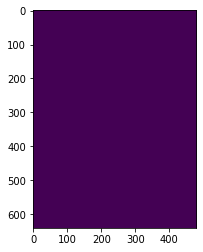

In [108]:
plt.imshow(np.argmax(out.permute(0, 2, 3, 1)[0].detach().numpy(), -1))

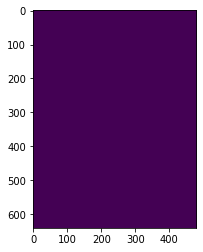

In [109]:
plt.imshow(np.argmax(out_tf[0].numpy(), -1))

In [110]:
from test import vis_parsing_maps
from PIL import Image
from torchvision import transforms

In [111]:
def predict(net, image_path, save_path):
    net.eval()
    
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406), 
            (0.229, 0.224, 0.225)
        ),
    ])
    
    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        
#         img = img.cuda()
        
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        print(parsing)
        print(parsing.shape)
        print(np.unique(parsing))

        vis_parsing_maps(image, parsing, stride=1, save_im=True, save_path=save_path)

In [112]:
predict(net, "./0.jpg", "pred0.jpg")

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]]
(512, 512)
[ 0  1  2  3  4  5 10 11 12 13 14 17 18]


In [113]:
def predict_tf(net, image_path, save_path):    
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406), 
            (0.229, 0.224, 0.225)
        ),
    ])
    
    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        
#         img = img.cuda()
        
        img = img.detach().numpy()
    img = np.transpose(img, (0, 2, 3, 1))
    print(f"img shape: {img.shape}")

    out = net(img)[0]
    print(f"out shape: {out.shape}")
    parsing = np.argmax(np.squeeze(out, 0), 2)
    print(parsing.shape)
    print(np.unique(parsing))

    vis_parsing_maps(image, parsing, stride=1, save_im=True, save_path=save_path)

In [114]:
predict_tf(net_tf, "./0.jpg", "pred0-tf.jpg")

img shape: (1, 512, 512, 3)
out shape: (1, 512, 512, 19)
(512, 512)
[ 0  1  2  3  4  5 10 11 12 13 14 17 18]


## Export model

In [129]:
def convert_model(model, input_shape=(512, 512, 3)):
    input = keras.layers.Input(shape=input_shape, name="image_input")
    outputs = model(input)
    
    _model = keras.models.Model(input, outputs[0])
    return _model

In [130]:
net_tf_converted = convert_model(net_tf)

In [131]:
net_tf_converted.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf_bi_se_net (TFBiSeNet)     ((None, 512, 512, 19), (N 13313088  
Total params: 13,313,088
Trainable params: 13,300,416
Non-trainable params: 12,672
_________________________________________________________________


In [132]:
net_tf_converted.save("./tf_saved_models/bisenet/", save_format="tf")

INFO:tensorflow:Assets written to: ./tf_saved_models/bisenet/assets


In [133]:
!saved_model_cli show --dir tf_saved_models/bisenet/ --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_4'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 512, 512, 3)
      name: serving_default_input_4:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['tf_bi_se_net'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 512, 512, 19)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [134]:
loaded = tf.saved_model.load("./tf_saved_models/bisenet/")
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [135]:
infer = loaded.signatures["serving_default"]

In [136]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'tf_bi_se_net': TensorSpec(shape=(None, 512, 512, 19), dtype=tf.float32, name='tf_bi_se_net')}


In [139]:
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406), 
        (0.229, 0.224, 0.225)
    ),
])

In [144]:
img = Image.open("./0.jpg")
image = img.resize((512, 512), Image.BILINEAR)
img = to_tensor(image)
img = torch.unsqueeze(img, 0)
        
#         img = img.cuda()
        
img = img.detach().numpy()
img = np.transpose(img, (0, 2, 3, 1))

In [145]:
img.shape

(1, 512, 512, 3)

In [146]:
labeling = infer(tf.constant(img))

In [150]:
pred = labeling["tf_bi_se_net"].numpy()

In [152]:
pred = pred[0]
pred.shape

(512, 512, 19)

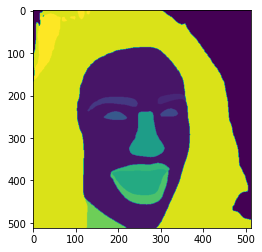

In [153]:
plt.imshow(np.argmax(pred, -1))